In [1]:
import pandas as pd
import numpy as np
import warnings
warnings.filterwarnings('ignore')
from numpy import sqrt 
import time

#Tien Xu Ly
from sklearn.preprocessing import MinMaxScaler

#Draw Flot
import matplotlib.pyplot as plt

#Cacuale error
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_absolute_percentage_error

#distance Libaray
from dtw import dtw
from scipy.spatial.distance import euclidean

#FFNN Libarary
from keras.models import Sequential
from keras.layers import Dense
from keras.callbacks import EarlyStopping
from sklearn.model_selection import GridSearchCV
from keras.wrappers.scikit_learn import KerasRegressor

In [2]:
# Đọc Dữ Liệu
# @param   filePath     Đường dẫn tập dữ liệu CSV
# @return  df           Tập dữ liệu csv dưới dạng df
def readData(filePath):
    # Load dữ liệu
    dataCSV = pd.read_csv(filePath)
    df=dataCSV[['Close']]
    return df

# Tiền Xử lý Dữ Liệu
# @param  Data   Tập dữ liệu
# @return df     Dữ liệu đã được tiền xử lý
def cleanData(df):
    # Replace null values with 0
    df.fillna(0, inplace=True)
    # Remove outliers by replacing values outside of 10 standard deviations with the mean
    std = df['Close'].std()
    mean = df['Close'].mean()
    df['Close'] = np.where(df['Close'] > (mean + 10*std), mean, df['Close'])
    df['Close'] = np.where(df['Close'] < (mean - 10*std), mean, df['Close'])
    # Scale data_AMZN to range [0, 1]
    scaler = MinMaxScaler()
    df['Close'] = scaler.fit_transform(df['Close'].values.reshape(-1, 1))
    # Fill in missing values with the mean of the previous and next values
    df['Close'] = df['Close'].interpolate(method='linear')
    return df

# Chia dữ liệu thành train set và test set
# @param  data                      Tập dữ liệu
# @param  percentTrain              Tỷ lệ Tập train
# @return train_data, test_data     Tập train và test   
def splitData(data, percentTrain):
    train_size = int(len(data) * (percentTrain/100))
    train = data.iloc[:train_size, :]
    test = data.iloc[train_size:, :]
    return train, test

# Xử lý dữ liệu thành dữ liệu đầu vào và đầu ra cho mô hình
# @param      data            Dữ liệu cần chia cửa sổ
# @param      size_window     Kích thước cửa sổ
# @param      size_predict    Kích thước cửa sổ dự đoán
# @param      stepWindow      số điểm dữ liệu trượt
# @return     X, y            mảng cửa sổ mẫu và mảng điểm dự đoán tương ứng
def prepare_data(data, size_window, size_predict, stepWindow):
    X, y = [], []
    startWindow = 0
    for i in range(len(data) - size_window - 1):
        if (len(data[(startWindow + size_window):(startWindow + size_window + size_predict) , 0]) != size_predict):
            break
        X.append(data[startWindow:(startWindow + size_window), :])
        y.append(data[(startWindow + size_window):(startWindow + size_window + size_predict) , 0])
        startWindow += stepWindow
    return np.array(X), np.array(y)

#---------KNN-----------
# Fucntion Tính khoảng cách giữa 2 chuỗi thời gian
# @param    ts1            Chuỗi thứ nhất
# @param    ts2            Chuỗi thứ hai
# @return   euclidean      Khoảng cách euclidean    
def euclidean_distance(ts1, ts2):
    ts1= ts1.flatten()
    ts2= ts2.flatten()
    return euclidean(ts1,ts2)

# Function lấy ra k chuỗi gần nhất
# @param    k             Số lượng chuỗi gần nhất
# @param    distanceArr   Mảng khoảng cách
# @return   argsort       Vị trí chuỗi gần nhất        
def kSimilarityTimeSeries(k, distanceArr):
    distances = np.array(distanceArr)
    return distances.argsort()[:k] 

# Tính khoảng cách DTW
# @param    ts1            Chuỗi thứ nhất
# @param    ts2            Chuỗi thứ hai
# @return   euclidean      Khoảng cách euclidean  
def dtw_dist(ts1, ts2):
    dist, _, _, _ = dtw(ts1, ts2, dist=lambda ts1, ts2: np.abs(ts1 - ts2))
    return dist

# Thêm Dữ liệu
# @param    X_train               Cửa sổ mẫu train
# @param    y_train               Cửa sổ dự đoán train
# @param    XTest                 Cửa sổ mẫu test
# @param    yTest                 Cửa sổ dự đoán test
# @return   X_train, y_train      Khoảng cách euclidean 
def toTrain(X_train, y_train, XTest, yTest):
    X_train.append(XTest)
    y_train.append(yTest)
    return np.array(X_train), np.array(y_train)

# Dự đoán Euclidean
# @param    nameData           Tên tập dữ liệu
# @param    k                  Số lượng chuỗi gần nhất
# @param    typeDistance       Độ đo sử dụng (Dtw, euclidean)
# @param    X_train            Cửa sổ mẫu train
# @param    y_train            Cửa sổ dự đoán train
# @param    X_test             Cửa sổ mẫu test
# @param    y_test             Cửa sổ dự đoán test
# @return   y_pred_arr         Mảng dự đoán
def predict_KNN(k, typeDistance, X_train, y_train, X_test, y_test):
    y_pred_arr=[]
    for iTest in range(len(X_test)):
        if(k>len(X_train)):
            k=len(X_train)
        distanceArr=[]
        for iTrain in range(len(X_train)-size_window+2):
            if(typeDistance == 'Dtw'):
                distance = dtw_dist(X_test[iTest],X_train[iTrain])
            else:
                distance = euclidean_distance(X_test[iTest],X_train[iTrain])
            distanceArr.append(distance)
        indexKNN= kSimilarityTimeSeries(k,distanceArr)
        y_pred = np.mean(y_train[indexKNN])
        y_pred_arr.append(y_pred)
        X_train, y_train = toTrain(X_train.tolist(), y_train.tolist(),X_test[iTest].tolist(), y_test[iTest].tolist())
        y_pred = np.array(y_pred_arr)
   
    return y_pred


#----------------FFNN--------------------------
# Khởi tạo mô hình FFNN
# @param    neuralInput         Kích thước Cửa sổ mẫu/ số neural lớp input
# @param    num_layers_hidden   Số lượng lớp ẩn
# @param    num_neural_hidden   Số neural lớp ẩn
# @param    neuralOutput         Số neural lớp ouput
# @return   model               Mô hình FFNN
def create_model_FFNN(neuralInput, num_layers_hidden=1, neuralHidden=1, neuralOutput=1):
    model = Sequential()
    for i in range(num_layers_hidden):
        if i == 0:
            model.add(Dense(neuralHidden, input_dim= neuralInput, activation='sigmoid'))
        else:
            model.add(Dense(neuralHidden, activation='sigmoid'))
    model.add(Dense(neuralOutput))
    model.compile(loss='mean_squared_error', optimizer='adam')
    return model


# Train FFNN 
# @param    nameData          Tên tập dữ liệu
# @param    size_window       Kích thước Cửa sổ mẫu/ số neural lớp input
# @param    X_train           cửa sổ mẫu tập train
# @param    y_train           Cửa sổ dự đoán tập train
# @param    neuralHidden      Số neural lớp ẩn
# @param    numHiddenLayer    Số lớp ẩn
# @param    size_predict      Kích thước Cửa sổ dự đoán/ Số neural lớp ouput
# @return   best_params_FFNN  Tham số tốt nhất cho mô hình FFNN                
def train_FFNN(nameData, typePredict, size_window, X_train, y_train, neuralHidden, numHiddenLayer, size_predict):
    #param search
    param_grid_FFNN = {'batch_size': [8, 16, 32, 64, 128],
              'epochs': [50, 100, 150, 200, 250, 300],
              'neuralHidden': [neuralHidden],
              'num_layers_hidden' : [numHiddenLayer],
              'neuralInput' : [size_window],
              'neuralOutput' : [size_predict]}

    # create the model
    model_FFNN = KerasRegressor(build_fn=create_model_FFNN, verbose=0)
    
    # perform the grid search
    grid_FFNN = GridSearchCV(estimator=model_FFNN, param_grid=param_grid_FFNN, cv=3)
    grid_result_FFNN = grid_FFNN.fit(X_train, y_train)
    
    # train the model with the best parameters
    best_params_FFNN = grid_result_FFNN.best_params_
    
    model_FFNN = create_model_FFNN( best_params_FFNN['neuralInput'], best_params_FFNN['num_layers_hidden'], best_params_FFNN['neuralHidden'],best_params_FFNN['neuralOutput'])
    model_FFNN.fit(X_train, y_train, epochs=best_params_FFNN['epochs'], batch_size=best_params_FFNN['batch_size'], verbose=2, callbacks=[EarlyStopping(monitor='loss', patience=10)], shuffle=False)
    
    if(typePredict=='FFNN_Find_NeuralHidden'):
        model_FFNN.save_weights('../BestParam/FFNN/'+nameData+'/FFNN_Find_NeuralHidden/'+str(int(best_params_FFNN['num_layers_hidden']))+'_HiddenLayer_'+str(int(best_params_FFNN['neuralHidden']))+'_NeuralHidden_'+str(int(best_params_FFNN['batch_size']))+'_BatchSize_'+str(int(best_params_FFNN['epochs']))+'_Epoch_'+nameData+'.h5')   
    elif (typePredict=='FFNN_Find_NumberHiddenLayer'):
        model_FFNN.save_weights('../BestParam/FFNN/'+nameData+'/FFNN_Find_NumberHiddenLayer/'+str(int(best_params_FFNN['num_layers_hidden']))+'_HiddenLayer_'+str(int(best_params_FFNN['neuralHidden']))+'_NeuralHidden_'+str(int(best_params_FFNN['batch_size']))+'_BatchSize_'+str(int(best_params_FFNN['epochs']))+'_Epoch_'+nameData+'.h5')   
    else:
        model_FFNN.save_weights('../BestParam/TuanTu/'+nameData+'/FFNN_Find_NumberHiddenLayer/'+str(int(best_params_FFNN['num_layers_hidden']))+'_HiddenLayer_'+str(int(best_params_FFNN['neuralHidden']))+'_NeuralHidden_'+str(int(best_params_FFNN['batch_size']))+'_BatchSize_'+str(int(best_params_FFNN['epochs']))+'_Epoch_'+nameData+'.h5')   
    return best_params_FFNN



# Train FFNN 
# @param    nameData          Tên tập dữ liệu
# @param    size_window       Kích thước Cửa sổ mẫu/ số neural lớp input
# @param    X_train           cửa sổ mẫu tập train
# @param    y_train           Cửa sổ dự đoán tập train
# @param    batchSize         Số lượng mẫu được đưa vào với mỗi lần lặp (epoch)
# @param    epoch             Số lần lặp cập nhật trọng số
# @param    neuralHidden      Số neural lớp ẩn
# @param    numHiddenLayer    Số lớp ẩn
# @param    size_predict      Kích thước Cửa sổ dự đoán/ Số neural lớp ouput
# @return   best_params_FFNN  Tham số tốt nhất cho mô hình FFNN                
def train_best_param_FFNN(nameData, typePredict, size_window, X_train, y_train, batchSize, epoch, neuralHidden, numHiddenLayer, size_predict):
    #param search
    param_grid_FFNN = {'batch_size': batchSize,
              'epochs': epoch,
              'neuralHidden': neuralHidden,
              'num_layers_hidden' : numHiddenLayer,
              'neuralInput' : size_window,
              'neuralOutput' : size_predict}
    
    model_FFNN = create_model_FFNN( param_grid_FFNN['neuralInput'], param_grid_FFNN['num_layers_hidden'], param_grid_FFNN['neuralHidden'],param_grid_FFNN['neuralOutput'])
    model_FFNN.fit(X_train, y_train, epochs=param_grid_FFNN['epochs'], batch_size=param_grid_FFNN['batch_size'], verbose=2, callbacks=[EarlyStopping(monitor='loss', patience=10)], shuffle=False)
    
    if(typePredict=='FFNN_Find_NeuralHidden'):
        model_FFNN.save_weights('../BestParam/FFNN/'+nameData+'/FFNN_Find_NeuralHidden/'+str(int(param_grid_FFNN['num_layers_hidden']))+'_HiddenLayer_'+str(int(param_grid_FFNN['neuralHidden']))+'_NeuralHidden_'+str(int(param_grid_FFNN['batch_size']))+'_BatchSize_'+str(int(param_grid_FFNN['epochs']))+'_Epoch_'+nameData+'.h5')   
    elif (typePredict=='FFNN_Find_NumberHiddenLayer'):
        model_FFNN.save_weights('../BestParam/FFNN/'+nameData+'/FFNN_Find_NumberHiddenLayer/'+str(int(param_grid_FFNN['num_layers_hidden']))+'_HiddenLayer_'+str(int(param_grid_FFNN['neuralHidden']))+'_NeuralHidden_'+str(int(param_grid_FFNN['batch_size']))+'_BatchSize_'+str(int(param_grid_FFNN['epochs']))+'_Epoch_'+nameData+'.h5')   
    elif (typePredict=='FFNN_Find_NumberHiddenLayer_SongSong'):
        model_FFNN.save_weights('../BestParam/SongSong/'+nameData+'/FFNN_Find_BestWeights/'+str(int(param_grid_FFNN['num_layers_hidden']))+'_HiddenLayer_'+str(int(param_grid_FFNN['neuralHidden']))+'_NeuralHidden_'+str(int(param_grid_FFNN['batch_size']))+'_BatchSize_'+str(int(param_grid_FFNN['epochs']))+'_Epoch_'+nameData+'.h5')   
    else:
        model_FFNN.save_weights('../BestParam/TuanTu/'+nameData+'/FFNN_Find_BestWeights/'+str(int(param_grid_FFNN['num_layers_hidden']))+'_HiddenLayer_'+str(int(param_grid_FFNN['neuralHidden']))+'_NeuralHidden_'+str(int(param_grid_FFNN['batch_size']))+'_BatchSize_'+str(int(param_grid_FFNN['epochs']))+'_Epoch_'+nameData+'.h5')   
   
    return param_grid_FFNN

# Dự Đoán FFNN 
# @param    nameData          Tên tập dữ liệu
# @param    typePredict       Thực hiện loại dự đoán (FFNN_Find_NeuralHidden,FFNN_Find_NumberHiddenLayer,CombinePredict)
# @param    X_train           cửa sổ mẫu tập train
# @param    y_train           Cửa sổ dự đoán tập train
# @param    X_test            Cửa sổ dự đoán tập train
# @param    best_params_FFNN  Cửa sổ dự đoán tập train
# @return   predictions_FFNN  Mảng dự đoán
def predict_FFNN(nameData, typePredict, X_train, y_train, X_test, best_params_FFNN):
    model_FFNN1 = Sequential()
    for i in range(best_params_FFNN['num_layers_hidden']):
        if i == 0:
            model_FFNN1.add(Dense(best_params_FFNN['neuralHidden'], input_dim= best_params_FFNN['neuralInput'], activation='sigmoid'))
        else:
            model_FFNN1.add(Dense(best_params_FFNN['neuralHidden'], activation='sigmoid'))
    model_FFNN1.add(Dense(best_params_FFNN['neuralOutput']))
    
    if(typePredict=='FFNN_Find_NeuralHidden'):
        model_FFNN1.load_weights('../BestParam/FFNN/'+nameData+'/FFNN_Find_NeuralHidden/'+str(int(best_params_FFNN['num_layers_hidden']))+'_HiddenLayer_'+str(int(best_params_FFNN['neuralHidden']))+'_NeuralHidden_'+str(int(best_params_FFNN['batch_size']))+'_BatchSize_'+str(int(best_params_FFNN['epochs']))+'_Epoch_'+nameData+'.h5')   
    elif (typePredict=='FFNN_Find_NumberHiddenLayer'):
        model_FFNN1.load_weights('../BestParam/FFNN/'+nameData+'/FFNN_Find_NumberHiddenLayer/'+str(int(best_params_FFNN['num_layers_hidden']))+'_HiddenLayer_'+str(int(best_params_FFNN['neuralHidden']))+'_NeuralHidden_'+str(int(best_params_FFNN['batch_size']))+'_BatchSize_'+str(int(best_params_FFNN['epochs']))+'_Epoch_'+nameData+'.h5')   
    elif (typePredict=='FFNN_Find_NumberHiddenLayer_SongSong'):
        model_FFNN1.load_weights('../BestParam/SongSong/'+nameData+'/FFNN_Find_BestWeights/'+str(int(best_params_FFNN['num_layers_hidden']))+'_HiddenLayer_'+str(int(best_params_FFNN['neuralHidden']))+'_NeuralHidden_'+str(int(best_params_FFNN['batch_size']))+'_BatchSize_'+str(int(best_params_FFNN['epochs']))+'_Epoch_'+nameData+'.h5')   
    else:
        model_FFNN1.load_weights('../BestParam/TuanTu/'+nameData+'/FFNN_Find_BestWeights/'+str(int(best_params_FFNN['num_layers_hidden']))+'_HiddenLayer_'+str(int(best_params_FFNN['neuralHidden']))+'_NeuralHidden_'+str(int(best_params_FFNN['batch_size']))+'_BatchSize_'+str(int(best_params_FFNN['epochs']))+'_Epoch_'+nameData+'.h5')   
   
    model_FFNN1.compile(loss='mean_squared_error', optimizer='adam')
    
    predictions_FFNN = model_FFNN1.predict(X_test)
    return predictions_FFNN

#---------------------Song Song------------------------------#

# Lai Ghép Song Song
# @param    y_pred_FFNN     Mảng dự đoán của FFNN
# @param    y_pred_KNN      Mảng dự đoán của KNN
# @param    y_test          Mảng chuỗi thực tế
# @return   y_pred_combine  Mảng dự đoán kết hợp
def predictHybrid(y_pred_FFNN,y_pred_KNN,y_test):
    FFNNSubKNN=[]
    TestSubKNN=[]
    weightEl=[]
    for i in range(len(y_pred_FFNN)):
        FFNNSubKNN.append(y_pred_FFNN[i]-y_pred_KNN[i])
        TestSubKNN.append(y_test[i]-y_pred_KNN[i])

    for j in range(len(FFNNSubKNN)):
        weightEl.append(((FFNNSubKNN[j]*TestSubKNN[j])/ (FFNNSubKNN[j]*FFNNSubKNN[j])))
    
    weight = np.array(weightEl)
    
    y_pred_combine=[]
    for i in range(len(weight)):
        y_pred_combine.append(weight[i]*y_pred_FFNN[i]+(1-weight[i])*y_pred_KNN[i])
    y_pred_combine=np.array(y_pred_combine)
    return y_pred_combine

#---------------------Tuần Tự------------------------------#

# Tính Lỗi Theo Từng Ngày
# @param    y_pred_KNN      Mảng dự đoán của KNN
# @param    y_test          Mảng chuỗi thực tế
# @return   mseWithDay     Mảng lỗi theo ngày
def mseWithDay(y_pred_KNN, y_test):
    mseDay = []
    for i in range(len(y_pred_KNN)):
        mseDay.append([abs((y_test[i] - y_pred_KNN[i]))])
    mseDay=np.array(mseDay)
    return mseDay

def predictSum(y_pred_mse,y_pred_KNN):
    pred_knn_ffnn=[]
    for i in range(len(y_pred_mse)):
        pred_knn_ffnn.append(y_pred_KNN[i]+y_pred_mse[i])
    pred_knn_ffnn=np.array(pred_knn_ffnn)
    return pred_knn_ffnn

In [3]:
df_MseWith_K_Euclidean = pd.DataFrame([],  columns =  ["K", "MSE","Time"])
df_MseWith_K_Dtw = pd.DataFrame([],  columns =  ["K", "MSE","Time"])

nameData= 'GDDY'
percentTrain = 80
filePath= '../../Dataset/'+nameData+'.csv'
timeSeries = readData(filePath)
timeSeries = cleanData(timeSeries)
train_data, test_data = splitData(timeSeries, percentTrain)
for k in range(1,21):
    #Eculidean
    size_window = 7
    size_predict=1
    stepWindow=1
    
    X_train, y_train = prepare_data(train_data.values, size_window, size_predict, stepWindow)
    X_test, y_test =   prepare_data(test_data.values, size_window, size_predict, stepWindow)
    
    start_KNN_Euclidean= time.time()
    y_pred_KNN_Euclidean= predict_KNN(k, 'Euclidean', X_train, y_train, X_test, y_test)
    end_KNN_Euclidean = time.time()
    np.savetxt('../BestParam/KNN/'+nameData+'/KNN_Euclidean_Find_K/'+str(k)+'_K_'+nameData+'.txt', y_pred_KNN_Euclidean)    
    rowMseWithK_Euclidean = pd.Series([k,mean_squared_error(y_test , y_pred_KNN_Euclidean), (end_KNN_Euclidean - start_KNN_Euclidean)], index=df_MseWith_K_Euclidean.columns)
    df_MseWith_K_Euclidean = df_MseWith_K_Euclidean.append(rowMseWithK_Euclidean,ignore_index=True)

    #Dtw
    X_train, y_train = prepare_data(train_data.values, size_window, size_predict, stepWindow)
    X_test, y_test = prepare_data(test_data.values, size_window, size_predict, stepWindow)
    start_KNN_Dtw= time.time()
    y_pred_KNN_Dtw = predict_KNN(k, 'Dtw', X_train, y_train, X_test, y_test)
    end_KNN_Dtw= time.time()
    np.savetxt('../BestParam/KNN/'+nameData+'/KNN_Dtw_Find_K/'+str(k)+'_K_'+nameData+'.txt', y_pred_KNN_Dtw)    
    rowMseWithK_Dtw = pd.Series([k, mean_squared_error(y_test , y_pred_KNN_Dtw), (end_KNN_Dtw - start_KNN_Dtw)], index=df_MseWith_K_Dtw.columns)
    df_MseWith_K_Dtw = df_MseWith_K_Dtw.append(rowMseWithK_Dtw,ignore_index=True)
   

In [4]:
df_MseWith_K_Euclidean

,K,MSE,Time
0,1.0,0.002014,10.638155
1,2.0,0.001830,10.616926
2,3.0,0.001775,10.691381
3,4.0,0.001712,10.519810
4,5.0,0.001706,10.799860
5,6.0,0.001732,10.995181
6,7.0,0.001757,10.825910
7,8.0,0.001773,10.913005
8,9.0,0.001786,10.831100
9,10.0,0.001777,10.980740


In [5]:
df_MseWith_K_Dtw

,K,MSE,Time
0,1.0,0.002158,153.313614
1,2.0,0.002053,152.878397
2,3.0,0.002055,152.999238
3,4.0,0.002059,153.153747
4,5.0,0.002028,155.067108
5,6.0,0.002033,154.137336
6,7.0,0.002019,154.506894
7,8.0,0.001996,154.231371
8,9.0,0.002015,155.476839
9,10.0,0.001990,156.105199


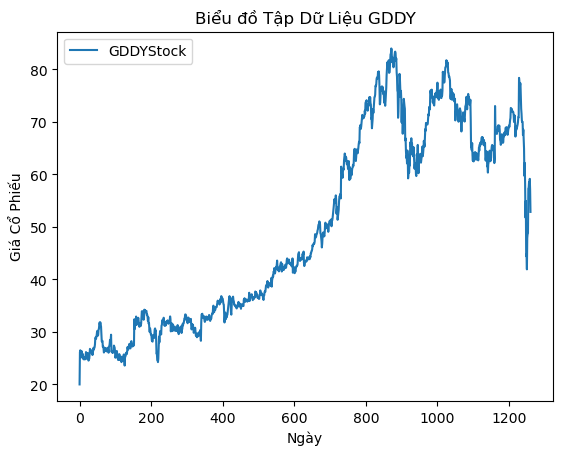

In [6]:
plt.title("Biểu đồ Tập Dữ Liệu "+nameData)
plt.plot(readData(filePath), label= nameData+'Stock')
plt.xlabel("Ngày")
plt.ylabel("Giá Cổ Phiếu")
plt.legend()
plt.show()


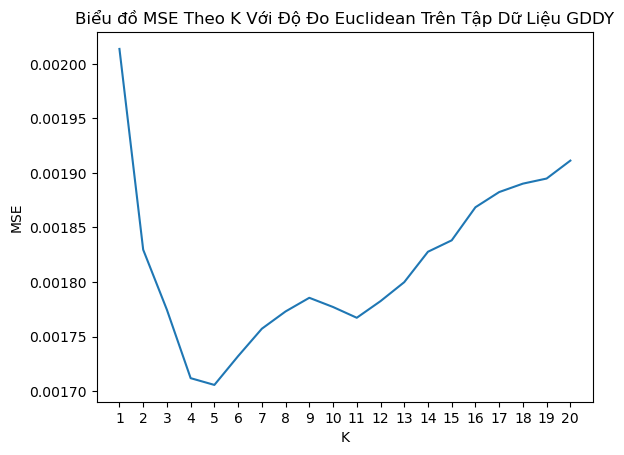

In [5]:
# Vẽ biểu đồ
plt.plot(range(1,len(df_MseWith_K_Euclidean[['MSE']])+1), df_MseWith_K_Euclidean[['MSE']])
plt.title("Biểu đồ MSE Theo K Với Độ Đo Euclidean Trên Tập Dữ Liệu " + nameData)
plt.xlabel("K")
plt.ylabel("MSE")
plt.xticks(range(1,len(df_MseWith_K_Euclidean[['MSE']])+1))
plt.show()

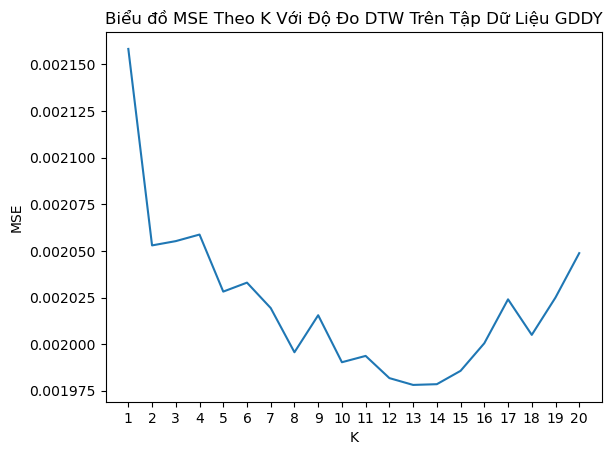

In [6]:
# Vẽ biểu đồ
plt.plot(range(1,len(df_MseWith_K_Dtw[['MSE']])+1), df_MseWith_K_Dtw[['MSE']])
plt.title("Biểu đồ MSE Theo K Với Độ Đo DTW Trên Tập Dữ Liệu " + nameData)
plt.xlabel("K")
plt.ylabel("MSE")
plt.xticks(range(1,len(df_MseWith_K_Dtw[['MSE']])+1))
plt.show()

In [9]:
# Euclidean
df_MseWith_K_Euclidean_Sort = df_MseWith_K_Euclidean.sort_values('MSE')
best_K_Euclidean=df_MseWith_K_Euclidean_Sort['K'].iloc[0]
# DTW
df_MseWith_K_Dtw_Sort = df_MseWith_K_Dtw.sort_values('MSE')
best_K_Dtw=df_MseWith_K_Dtw_Sort['K'].iloc[0]

In [10]:
df_MseWith_K_Euclidean_Sort

,K,MSE,Time
4,5.0,0.001706,10.799860
3,4.0,0.001712,10.519810
5,6.0,0.001732,10.995181
6,7.0,0.001757,10.825910
10,11.0,0.001767,10.807251
7,8.0,0.001773,10.913005
2,3.0,0.001775,10.691381
9,10.0,0.001777,10.980740
11,12.0,0.001782,10.930551
8,9.0,0.001786,10.831100


In [11]:
df_MseWith_K_Dtw_Sort

,K,MSE,Time
12,13.0,0.001978,156.184157
13,14.0,0.001979,151.779145
11,12.0,0.001982,154.093460
14,15.0,0.001986,122.841213
9,10.0,0.001990,156.105199
10,11.0,0.001994,155.532150
7,8.0,0.001996,154.231371
15,16.0,0.002000,120.892338
17,18.0,0.002005,120.095963
8,9.0,0.002015,155.476839


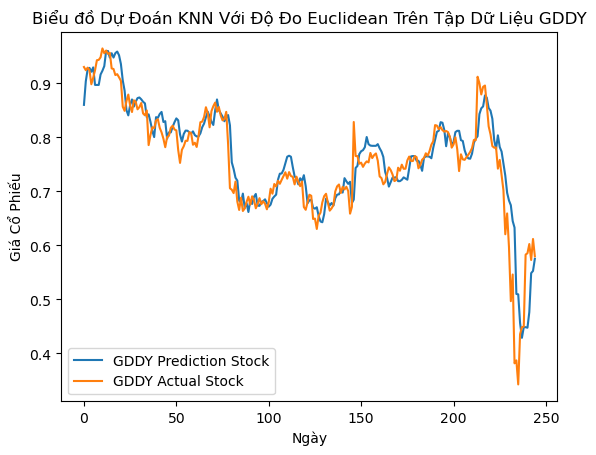

In [12]:
y_pred_KNN_Euclidean= np.loadtxt('../BestParam/KNN/'+nameData+'/KNN_Euclidean_Find_K/'+str(int(best_K_Euclidean))+'_K_'+nameData+'.txt')    
# Vẽ biểu đồ
plt.title("Biểu đồ Dự Đoán KNN Với Độ Đo Euclidean Trên Tập Dữ Liệu "+nameData)
plt.plot(y_pred_KNN_Euclidean, label=nameData+' Prediction Stock')
plt.plot(y_test, label=nameData+' Actual Stock')
plt.xlabel("Ngày")
plt.ylabel("Giá Cổ Phiếu")
plt.legend()
plt.show()

In [9]:
print("MSE Euclidean: " + str(mean_squared_error(y_test , y_pred_KNN_Euclidean)))
print("RMSE Euclidean: " + str(sqrt(mean_squared_error(y_test, y_pred_KNN_Euclidean)) ))
print("MAE Euclidean: " + str(mean_absolute_error(y_test,y_pred_KNN_Euclidean)))
print("MAPE Euclidean: " + str(mean_absolute_percentage_error(y_test, y_pred_KNN_Euclidean)))

MSE Euclidean: 0.001705747520485175
RMSE Euclidean: 0.04130069636804173
MAE Euclidean: 0.02620434089582793
MAPE Euclidean: 0.03891346411843174


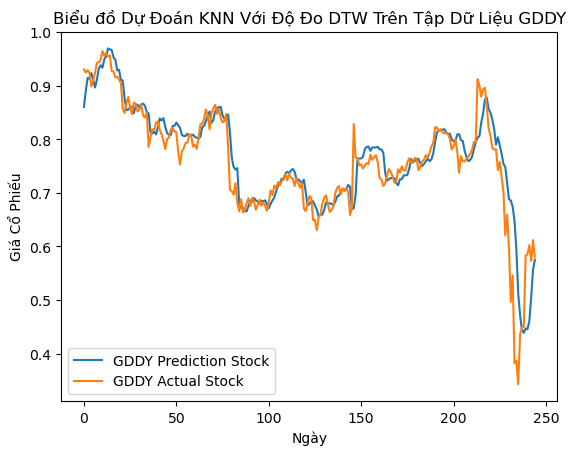

In [13]:
y_pred_KNN_Dtw = np.loadtxt('../BestParam/KNN/'+nameData+'/KNN_Dtw_Find_K/'+str(int(best_K_Dtw))+'_K_'+nameData+'.txt')    
# Vẽ biểu đồ
plt.title("Biểu đồ Dự Đoán KNN Với Độ Đo DTW Trên Tập Dữ Liệu "+nameData)
plt.plot(y_pred_KNN_Dtw, label=nameData+' Prediction Stock')
plt.plot(y_test, label=nameData+' Actual Stock')
plt.xlabel("Ngày")
plt.ylabel("Giá Cổ Phiếu")
plt.legend()
plt.show()

In [10]:
print("MSE Dtw: " + str(mean_squared_error(y_test , y_pred_KNN_Dtw)))
print("RMSE Dtw: " + str(sqrt(mean_squared_error(y_test, y_pred_KNN_Dtw)) ))
print("MAE Dtw: " + str(mean_absolute_error(y_test,y_pred_KNN_Dtw)))
print("MAPE Dtw: " + str(mean_absolute_percentage_error(y_test, y_pred_KNN_Dtw)))

MSE Dtw: 0.0019781139120675258
RMSE Dtw: 0.04447599253605844
MAE Dtw: 0.026318783325901957
MAPE Dtw: 0.03993512647508461


# Load Predict KNN

In [7]:
# df_MseWith_K_Euclidean = pd.DataFrame([],  columns =  ["K", "MSE"])
# df_MseWith_K_Dtw = pd.DataFrame([],  columns =  ["K", "MSE"])

# nameData= 'GDDY'
# percentTrain = 80
# filePath= '../../Dataset/'+nameData+'.csv'
# timeSeries = readData(filePath)
# timeSeries = cleanData(timeSeries)
# train_data, test_data = splitData(timeSeries, percentTrain)

# for k in range(1,21):
#     X_train, y_train = prepare_data(train_data.values, 7, 1, 1)
#     X_test, y_test = prepare_data(test_data.values, 7, 1, 1)
    
#     y_pred_KNN_Eculidean= np.loadtxt('../BestParam/KNN/'+nameData+'/KNN_Euclidean_Find_K/'+str(k)+'_K_'+nameData+'.txt')    
#     rowMseWithK_Euclidean = pd.Series([k,mean_squared_error(y_test , y_pred_KNN_Eculidean)], index=df_MseWith_K_Euclidean.columns)
#     df_MseWith_K_Euclidean = df_MseWith_K_Euclidean.append(rowMseWithK_Euclidean,ignore_index=True)
    
#     y_pred_KNN_Dtw = np.loadtxt('../BestParam/KNN/'+nameData+'/KNN_Dtw_Find_K/'+str(k)+'_K_'+nameData+'.txt')    
#     rowMseWithK_Dtw = pd.Series([k,mean_squared_error(y_test , y_pred_KNN_Dtw)], index=df_MseWith_K_Dtw.columns)
#     df_MseWith_K_Dtw = df_MseWith_K_Dtw.append(rowMseWithK_Dtw,ignore_index=True)
# print(df_MseWith_K_Euclidean)
# print(df_MseWith_K_Dtw)

       K       MSE
0    1.0  0.002014
1    2.0  0.001830
2    3.0  0.001775
3    4.0  0.001712
4    5.0  0.001706
5    6.0  0.001732
6    7.0  0.001757
7    8.0  0.001773
8    9.0  0.001786
9   10.0  0.001777
10  11.0  0.001767
11  12.0  0.001782
12  13.0  0.001800
13  14.0  0.001828
14  15.0  0.001838
15  16.0  0.001869
16  17.0  0.001882
17  18.0  0.001890
18  19.0  0.001895
19  20.0  0.001911
       K       MSE
0    1.0  0.002158
1    2.0  0.002053
2    3.0  0.002055
3    4.0  0.002059
4    5.0  0.002028
5    6.0  0.002033
6    7.0  0.002019
7    8.0  0.001996
8    9.0  0.002015
9   10.0  0.001990
10  11.0  0.001994
11  12.0  0.001982
12  13.0  0.001978
13  14.0  0.001979
14  15.0  0.001986
15  16.0  0.002000
16  17.0  0.002024
17  18.0  0.002005
18  19.0  0.002025
19  20.0  0.002049


Thay thế các giá trị null bằng 0 .

Loại bỏ các giá trị nhiễu bằng cách thay thế các giá trị nằm ngoài khoảng 3 độ lệch chuẩn của dữ liệu với giá trị trung bình của dữ liệu.

MinMaxScaler để chuyển đổi dữ liệu thành phạm vi [0, 1]. Tiếp theo, chúng ta sử dụng 

Interpolate để điền vào các giá trị bị thiếu bằng cách lấy trung bình của các giá trị trước và sau đó.


std() là một hàm trong Python để tính độ lệch chuẩn của một tập dữ liệu. 

Công thức tính độ lệch chuẩn của một tập dữ liệu là:
σ = sqrt(1/n * Σ(xi - x_mean)^2)

Ví dụ, nếu chúng ta có tập dữ liệu [2, 4, 6, 8], thì giá trị trung bình là 5, độ lệch của mỗi giá trị so với giá trị trung bình lần lượt là [-3, -1, 1, 3], giá trị bình phương độ lệch của mỗi giá trị so với giá trị trung bình lần lượt là [9, 1, 1, 9], đưa vào công thức độ lệch chuẩn
 ==> σ = sqrt(1/4 * (9 + 1 + 1 + 9)) = sqrt(20/4) = sqrt(5) ≈ 2.236

